In [4]:
pip install pandas numpy matplotlib seaborn scikit-learn boto3 awscli

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import regularizers
!pip install xgboost
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from tensorflow.keras.utils import plot_model
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 

In [6]:
import boto3
import pandas as pd

s3_client = boto3.client('s3')
bucket_name = 'intrusiondetectionsystem'
train_key = 'Training Dataset/KDDTrain+.txt'
test_key = 'Testing Dataset /KDDTest+.txt'

In [7]:
# Load training data
train_obj = s3_client.get_object(Bucket=bucket_name, Key=train_key)
data_train = pd.read_csv(train_obj['Body'], header=None)



In [8]:
response = s3_client.list_objects_v2(Bucket=bucket_name)
for obj in response.get('Contents', []):
    print(obj['Key'])


Testing Dataset /
Testing Dataset /KDDTest+.txt
Training Dataset/
Training Dataset/KDDTrain+.txt


In [9]:
# Load testing data
test_obj = s3_client.get_object(Bucket=bucket_name, Key=test_key)
test_data = pd.read_csv(test_obj['Body'], header=None)

In [10]:
data_train.columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])


In [11]:
print(data_train.head())      # View the first few rows

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   
4               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0      

In [12]:
print(data_train.info())      # Check data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [13]:
data_train.describe().style.background_gradient(cmap='Greys').set_properties(**{'font-family':'Georgia Bold'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.144650,45566.743000,19779.114421,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.515310,5870331.181891,4021269.151440,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.000000,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [14]:
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

In [15]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

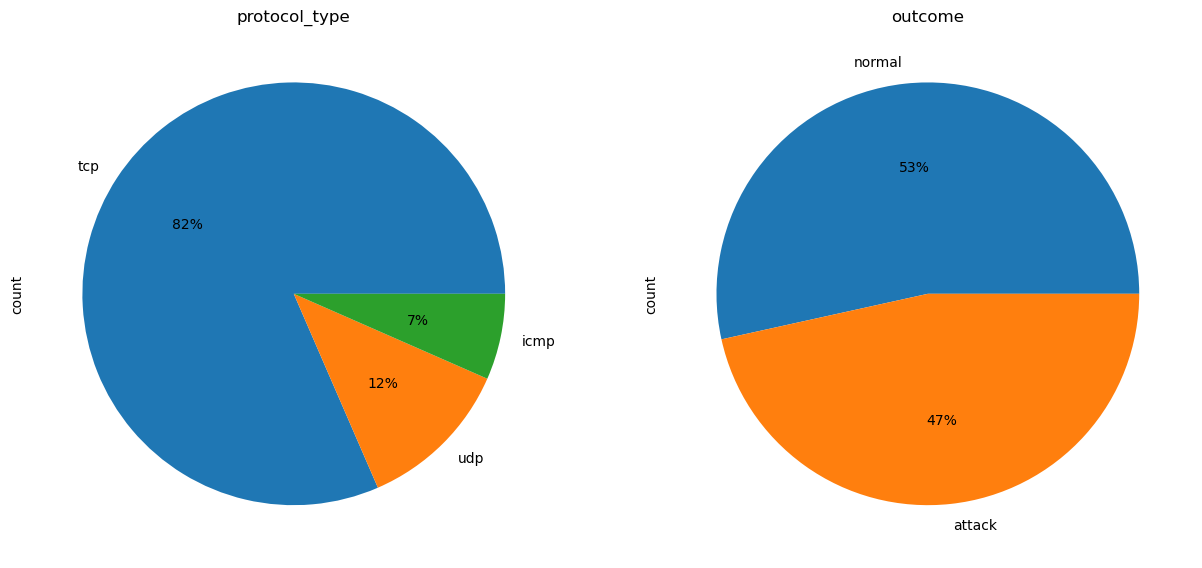

In [16]:
pie_plot (data_train, ['protocol_type', 'outcome'], 1, 2)

In [17]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

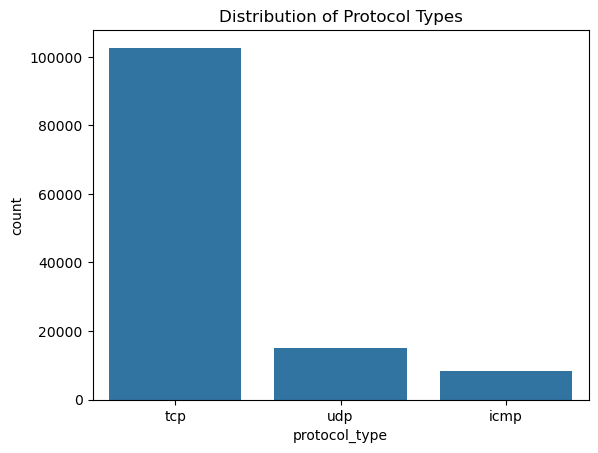

In [18]:
import seaborn as sns

sns.countplot(x='protocol_type', data=data_train)
plt.title('Distribution of Protocol Types')
plt.show()

In [19]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [20]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [21]:
scaled_train = preprocess(data_train)

In [22]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values
y_reg = scaled_train['level'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


In [23]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))

    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)


Training Accuracy Logistic Regression 89.38558018615174  Test Accuracy Logistic Regression 88.84302440960508
Training Precesion Logistic Regression 88.53203188269894  Test Precesion Logistic Regression 88.071367884452
Training Recall Logistic Regression 88.6548434598886  Test Recall Logistic Regression 88.0489255075172


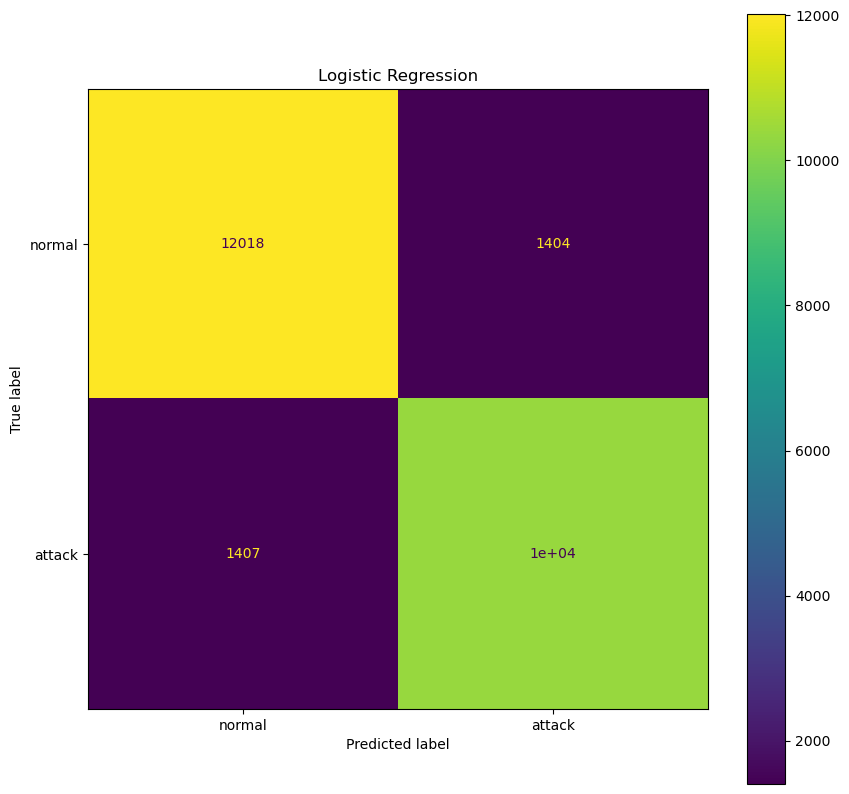

In [24]:
lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)
plt.title('Logistic Regression')
plt.show()

Training Accuracy RandomForestClassifier 99.99801543987775  Test Accuracy RandomForestClassifier 99.88489779718198
Training Precesion RandomForestClassifier 99.99786584715197  Test Precesion RandomForestClassifier 99.94896223205171
Training Recall RandomForestClassifier 99.99786584715197  Test Recall RandomForestClassifier 99.80463773040007


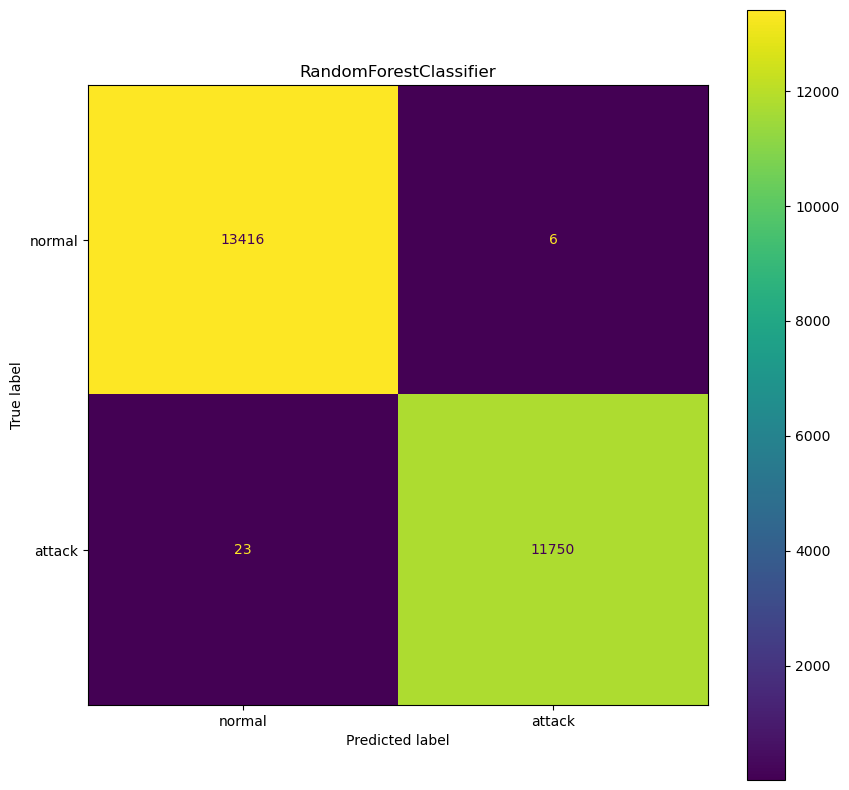

In [25]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)
plt.title('RandomForestClassifier')
plt.show()

Training Accuracy Linear SVC(LBasedImpl) 97.13231062335034  Test Accuracy Linear SVC(LBasedImpl) 96.89224052391347
Training Precesion Linear SVC(LBasedImpl) 97.93715519309187  Test Precesion Linear SVC(LBasedImpl) 97.70793540545235
Training Recall Linear SVC(LBasedImpl) 95.85120686343555  Test Recall Linear SVC(LBasedImpl) 95.59160791641892


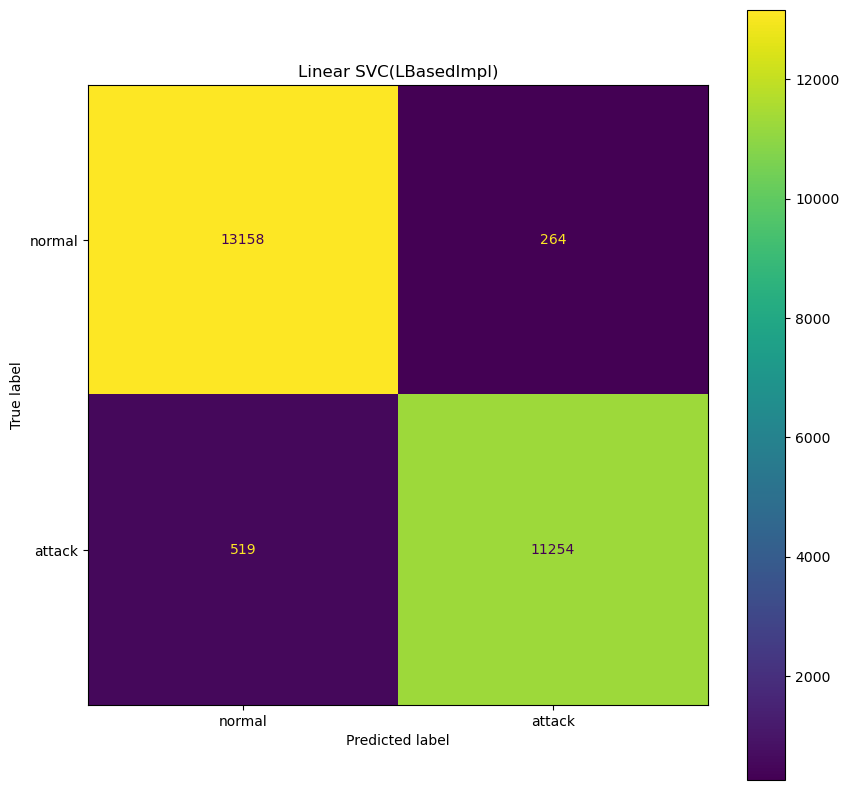

In [26]:
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)
plt.title('Linear SVC(LBasedImpl)')
plt.show()

Training Accuracy DecisionTreeClassifier 99.99801543987775  Test Accuracy DecisionTreeClassifier 99.8571145068466
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 99.8555772661626
Training Recall DecisionTreeClassifier 99.99573169430394  Test Recall DecisionTreeClassifier 99.83861377728701


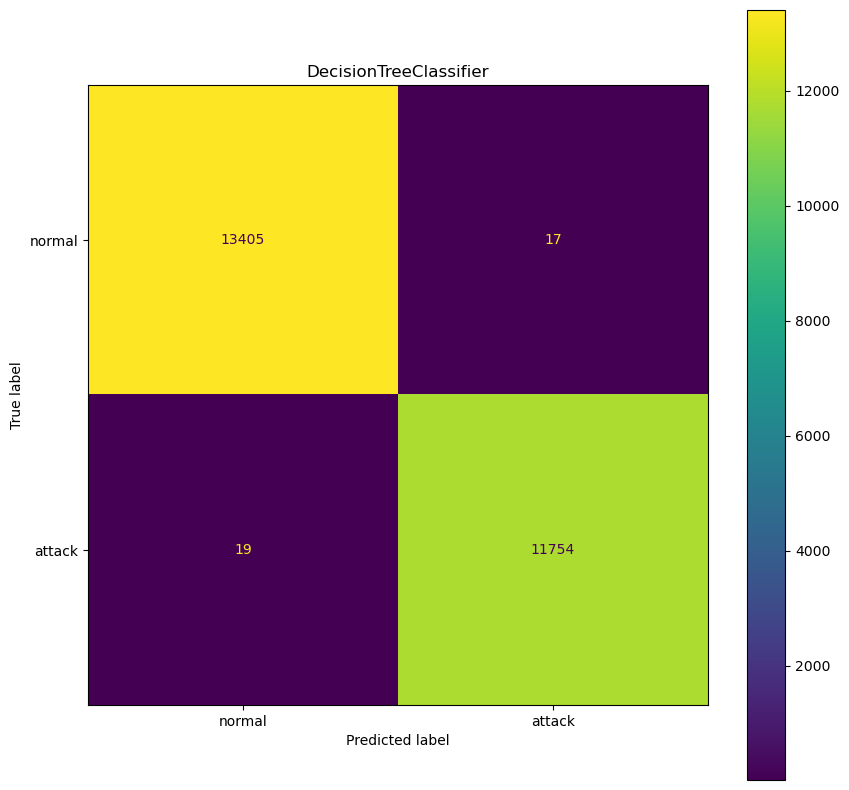

In [27]:
dt = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)
plt.title('DecisionTreeClassifier')
plt.show()

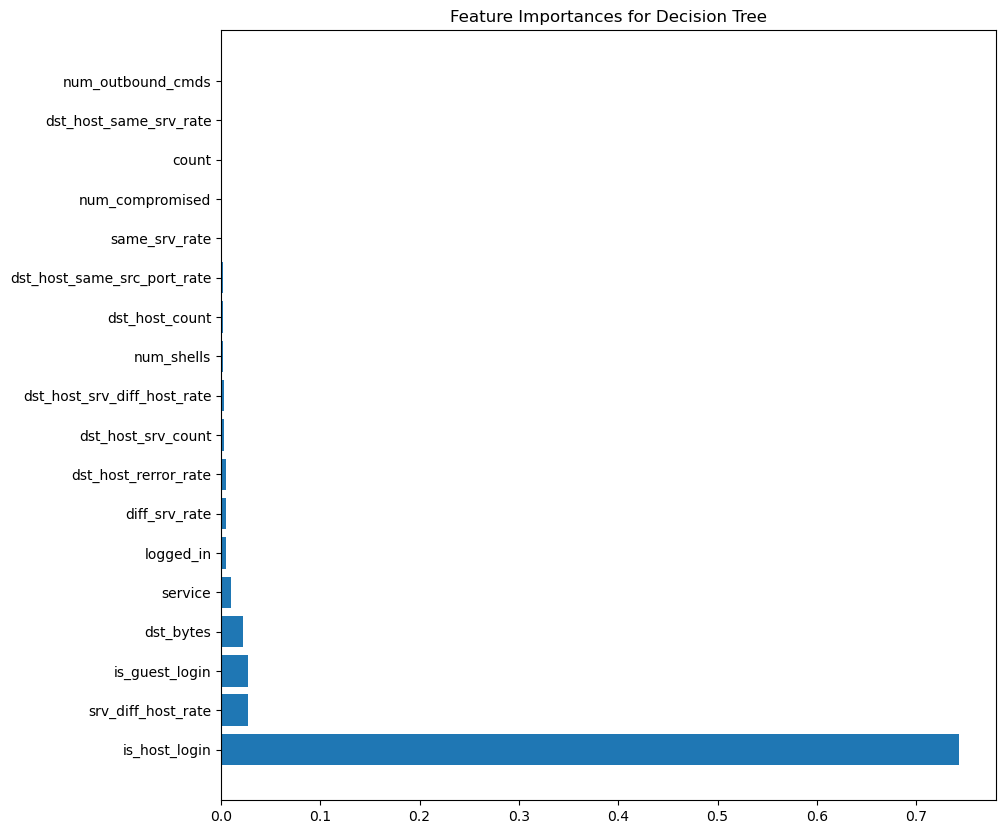

In [28]:
import matplotlib.pyplot as plt

def f_importances(coef, names, top=-1):
    # Ensure coef and names are in sync
    imp, names = zip(*sorted(zip(coef, names), reverse=True))  # Sort by importance descending

    # Default to showing all features
    if top == -1:
        top = len(names)
    
    plt.figure(figsize=(10, 10))
    plt.barh(range(top), imp[:top], align='center')  # Use the top features
    plt.yticks(range(top), names[:top])
    plt.title('Feature Importances for Decision Tree')
    plt.show()

# Drop the target columns to get feature names
feature_names = data_train.drop(['outcome', 'level'], axis=1).columns

# Ensure tdt is fitted and has feature_importances_
if hasattr(tdt, 'feature_importances_'):
    f_importances(abs(tdt.feature_importances_), feature_names, top=18)
else:
    print("The model 'tdt' does not have 'feature_importances_' attribute. Ensure it is a tree-based model and is fitted.")


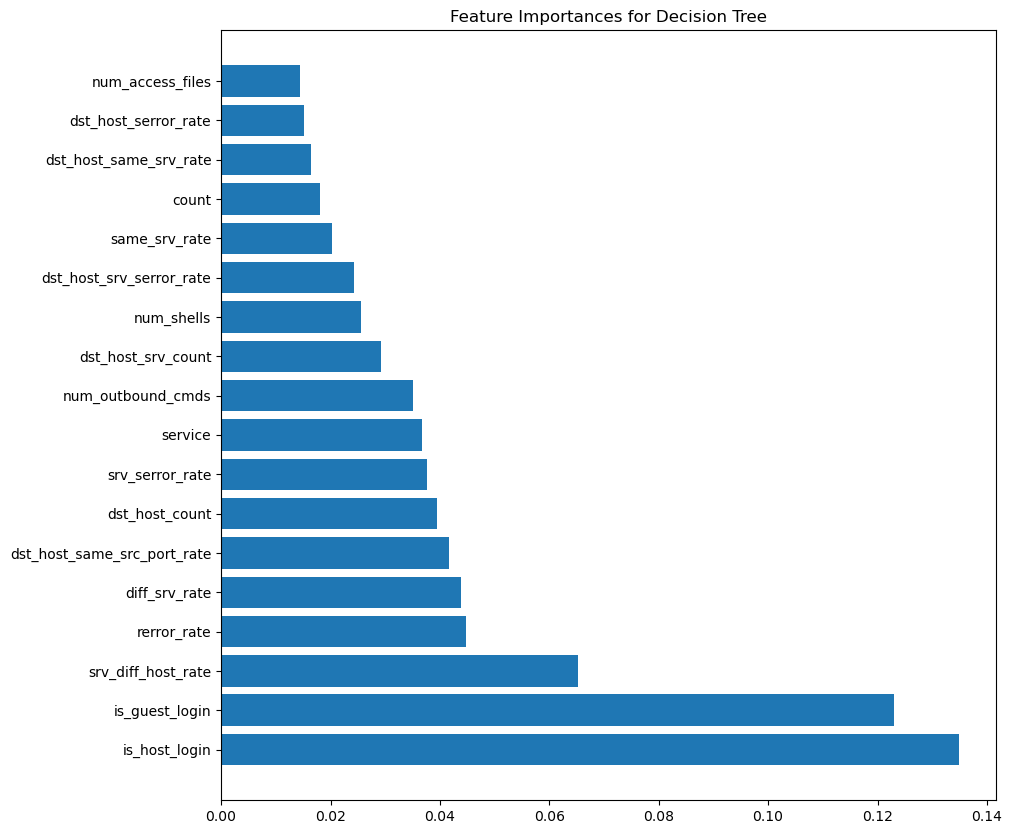

In [29]:
f_importances(abs(rf.feature_importances_), feature_names, top=18)

In [30]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)


[Text(0.5, 0.875, 'x[5] <= -0.056\ngini = 0.498\nsamples = 100778\nvalue = [53921, 46857]'),
 Text(0.25, 0.625, 'x[65] <= 0.5\ngini = 0.149\nsamples = 46582\nvalue = [3781, 42801]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[6] <= 0.007\ngini = 0.061\nsamples = 43109\nvalue = [1357, 41752]'),
 Text(0.0625, 0.125, 'gini = 0.031\nsamples = 42264\nvalue = [669.0, 41595.0]'),
 Text(0.1875, 0.125, 'gini = 0.303\nsamples = 845\nvalue = [688, 157]'),
 Text(0.375, 0.375, 'x[30] <= -0.211\ngini = 0.422\nsamples = 3473\nvalue = [2424, 1049]'),
 Text(0.3125, 0.125, 'gini = 0.025\nsamples = 1027\nvalue = [13, 1014]'),
 Text(0.4375, 0.125, 'gini = 0.028\nsamples = 2446\nvalue = [2411, 35]'),
 Text(0.75, 0.625, 'x[56] <= 0.5\ngini = 0.138\nsamples = 54196\nvalue = [50140, 4056]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[9] <= 0.5\ngini = 0.067\nsamples = 51782\nvalue = [49996.0, 1786.0]'),
 Text(0.5625, 0.125, 'gini = 0.027\nsamples = 49675\nvalue = [49007, 668]'),
 Text(0.6

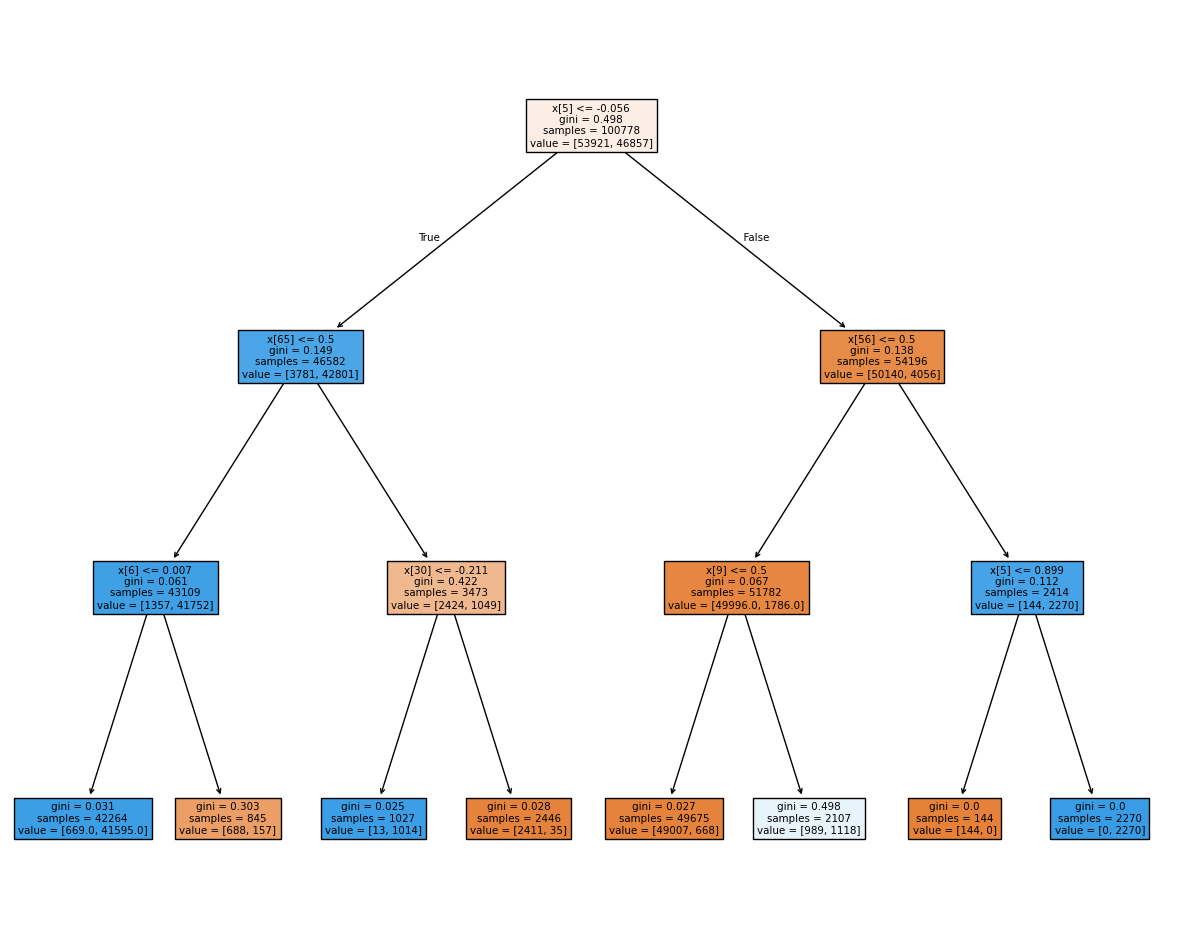

In [31]:
plt.show()

In [32]:
xg_r = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 20).fit(x_train_reg, y_train_reg)

In [33]:
name = "XGBOOST"
train_error = metrics.mean_squared_error(y_train_reg, xg_r.predict(x_train_reg), squared=False)
test_error = metrics.mean_squared_error(y_test_reg, xg_r.predict(x_test_reg), squared=False)
print("Training Error " + str(name) + " {}  Test error ".format(train_error) + str(name) + " {}".format(test_error))

Training Error XGBOOST 0.9228150948429511  Test error XGBOOST 1.0384702662812937


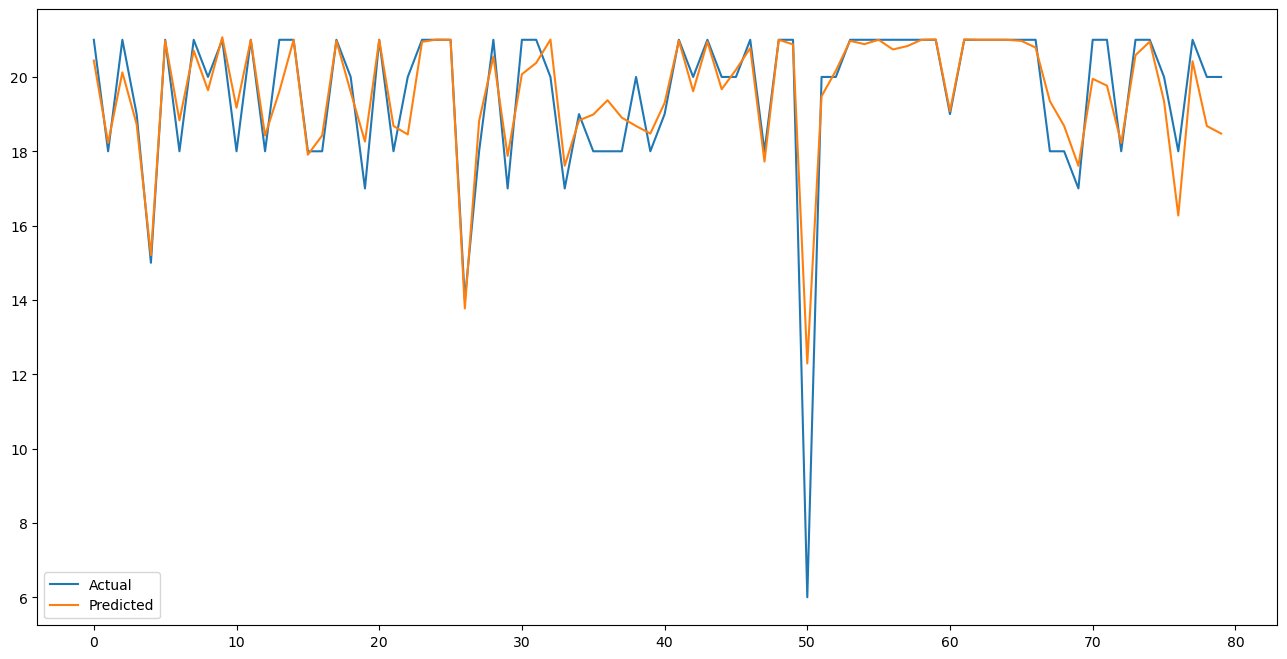

In [34]:
y_pred = xg_r.predict(x_test_reg)
df = pd.DataFrame({"Y_test": y_test_reg , "Y_pred" : y_pred})
plt.figure(figsize=(16,8))
plt.plot(df[:80])
plt.legend(['Actual' , 'Predicted'])
plt.show()

Training Accuracy PCA RandomForest 99.99801543987775  Test Accuracy PCA RandomForest 99.8293312165112
Training Precesion PCA RandomForest 99.99786584715197  Test Precesion PCA RandomForest 99.88941816944539
Training Recall PCA RandomForest 99.99786584715197  Test Recall PCA RandomForest 99.74517964834791


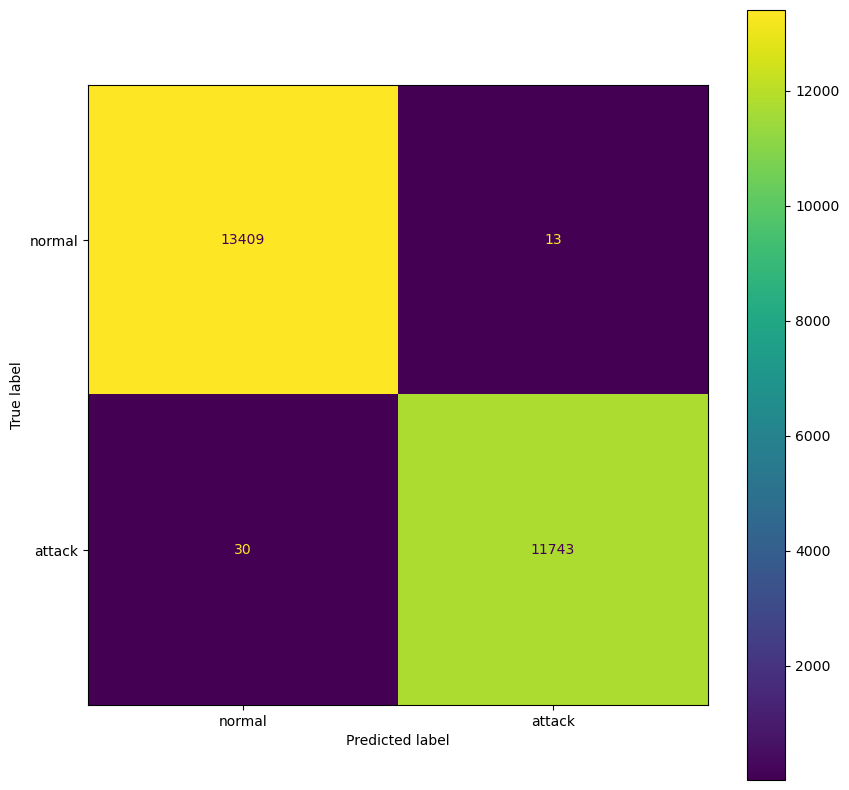

In [35]:
#Measuring the effect of PCA 
rrf = RandomForestClassifier().fit(x_train_reduced, y_train_reduced)
evaluate_classification(rrf, "PCA RandomForest", x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)
plt.show()

Training Accuracy KNeighborsClassifier 99.02260413979242  Test Accuracy KNeighborsClassifier 98.8727922206787
Training Precesion KNeighborsClassifier 99.18089029933957  Test Precesion KNeighborsClassifier 99.01868760133117
Training Recall KNeighborsClassifier 98.71310583263974  Test Recall KNeighborsClassifier 98.56451201902658


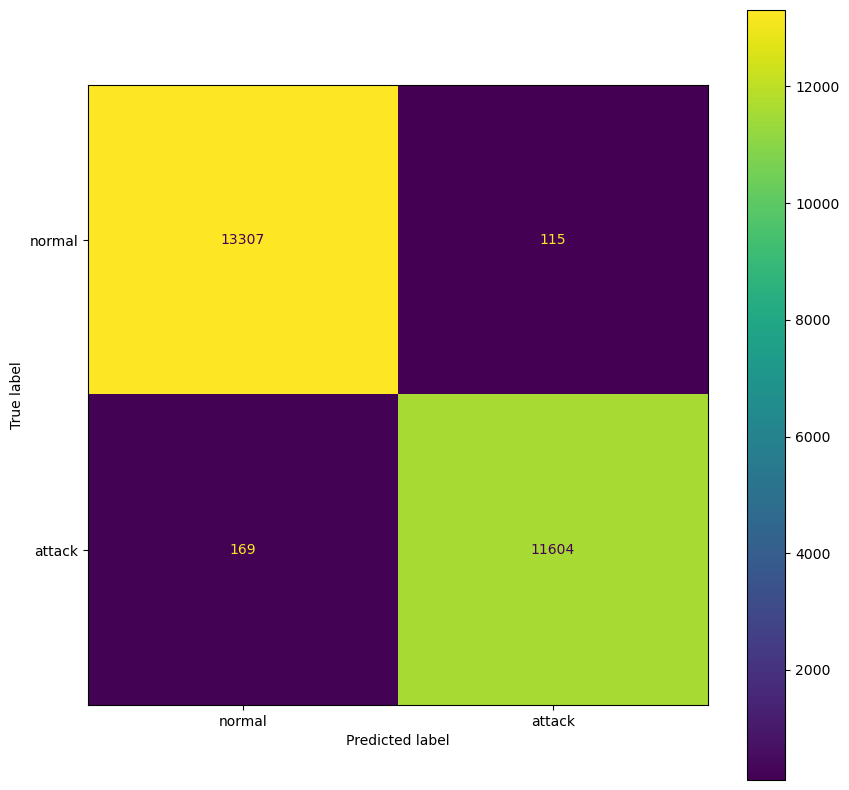

In [36]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)
plt.show()

Training Accuracy GaussianNB 87.40895830439183  Test Accuracy GaussianNB 87.14030561619369
Training Precesion GaussianNB 91.79469615422252  Test Precesion GaussianNB 91.29803504017036
Training Recall GaussianNB 80.07768316366818  Test Recall GaussianNB 80.1155185594156


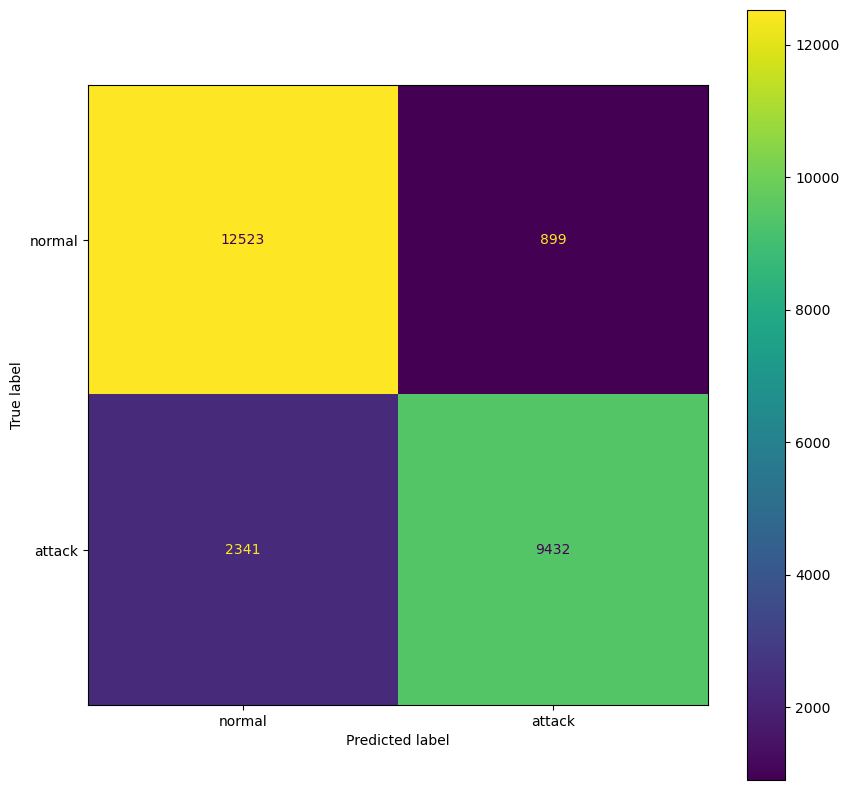

In [37]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)
plt.show()

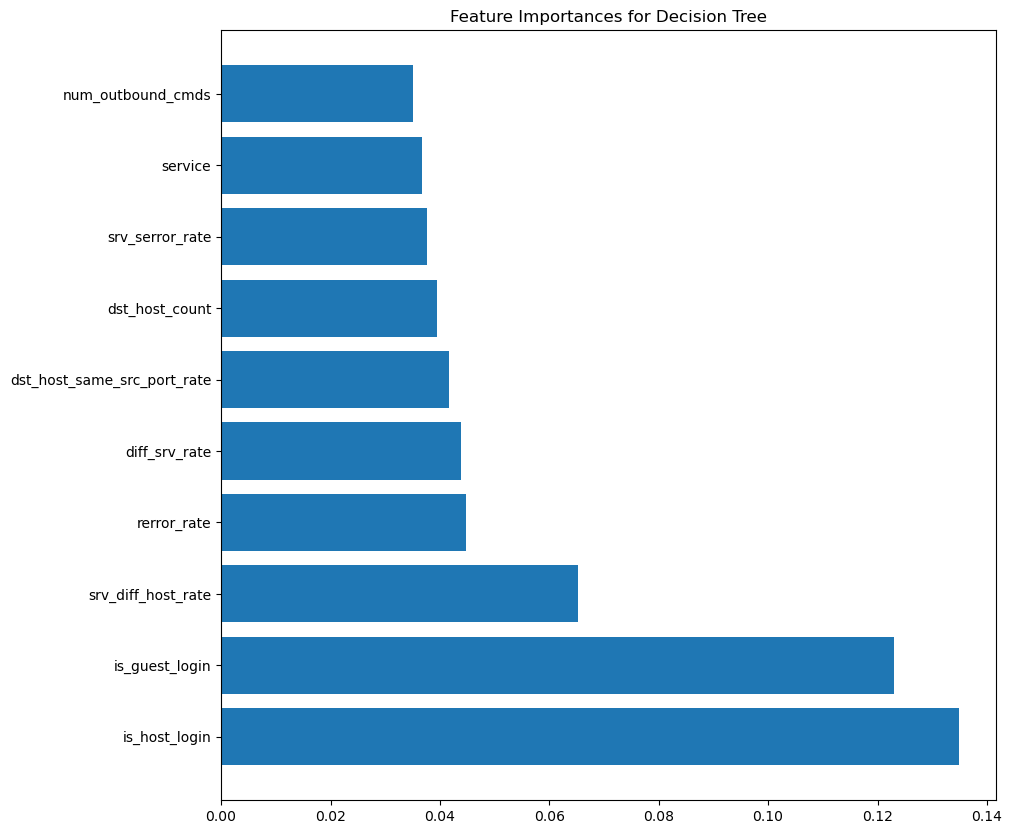

In [38]:
f_importances(abs(rf.feature_importances_), feature_names, top=10)